# Import Libaraies

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.patches as patches
from PIL import Image
import io
import json

In [ ]:
with open('credentials.json') as f:
    credentials = json.load(f)

aws_access_key_id = credentials['aws_access_key_id']
aws_secret_access_key = credentials['aws_secret_access_key']
rekognition = boto3.client(
    'rekognition',
    region_name='us-east-1',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)

confidence_threshold = 50
image_path = './pics/IMG_1348_crop.JPG'

# Get Rekognition Response

In [39]:
def get_amazon_response(im, rekog):
    im_pil = Image.fromarray(im)
    buffer = io.BytesIO()
    im_pil.save(buffer, format='JPEG')
    image_bytes = buffer.getvalue()
    return rekog.detect_text(
        Image={'Bytes': image_bytes}
    )

def analyze_line_location(line_collection):
    lines = line_collection.copy()
    for line in lines:
        p = line['Geometry']['Polygon']
        min_x = min(p[0]['X'],p[1]['X'],p[2]['X'],p[3]['X'])
        max_x = max(p[0]['X'],p[1]['X'],p[2]['X'],p[3]['X'])
        min_y = min(p[0]['Y'],p[1]['Y'],p[2]['Y'],p[3]['Y'])
        max_y = max(p[0]['Y'],p[1]['Y'],p[2]['Y'],p[3]['Y'])

        w1 = p[0]["X"] - p[1]["X"]
        h1 = p[1]["Y"] - p[0]["Y"]
        slope1 = (h1*im.shape[0]) / (w1*im.shape[1])
        w2 = p[1]["X"] - p[2]["X"]
        h2 = p[2]["Y"] - p[1]["Y"]
        slope2 = (h2*im.shape[0]) / (w2*im.shape[1])
        line['slopes'] = (-slope1, -slope2)

        line['width'] = sqrt(h1**2 + w1**2)
        line['height'] = sqrt(h2**2 + w2**2)

        if line['Geometry']['BoundingBox']['Height'] > line['Geometry']['BoundingBox']['Width']:
            if p[0]['X'] == max_x and p[3]['Y'] == min_y:
                line['direction'] = 'vertical right lean'
            elif p[3]['X'] == min_x and p[0]['Y'] == min_y:
                line['direction'] = 'vertical left lean'
            else:
                line['direction'] = 'unknown'
        else:
            if p[0]['X'] == max_x and p[3]['Y'] == min_y:
                line['direction'] = 'horizontal left lean'
            elif p[3]['X'] == min_x and p[0]['Y'] == min_y:
                line['direction'] = 'horizontal right lean'
            else:
                line['direction'] = 'unknown'


        x_cords = [pol['X'] for pol in p]
        y_cords = [pol['Y'] for pol in p]

        line['mid_point'] = (sum(x_cords) / len(x_cords), sum(y_cords) / len(y_cords))
    return lines

def is_point_within_middle(x, y, s, b1, b2):
    y1 = s * x + b1
    y2 = s * x + b2
    # plot_line(s, b1)
    # plot_line(s, b2)
    return min(y1, y2) <= y <= max(y1, y2)

def check_points(points, s1, P1, P2):

    points = [{'X': point['X'] * im.shape[1], 'Y': point['Y'] * im.shape[0]} for point in points]

    b1 = P1['Y']*im.shape[0] - s1 * P1['X']*im.shape[1]
    b2 = P2['Y']*im.shape[0] - s1 * P2['X']*im.shape[1]

    counter = 0
    for point in points:
        X = point['X']
        Y = point['Y']
        if is_point_within_middle(X, Y, s1, b1, b2):
            counter += 1

    left_side = 0
    right_side = 0
    # Check if the counter is 0 before proceeding
    if counter != 4:
        for point in points:
            # Calculate the y-values using the given slope (s1) and intercepts (b1, b2) for each X
            y_value_1 = s1 * point['X'] + b1
            y_value_2 = s1 * point['X'] + b2

            # Determine the position of the point relative to the lines
            if point['Y'] <= min(y_value_1, y_value_2):
                left_side += 1
            if point['Y'] >= max(y_value_1, y_value_2):
                right_side += 1
    if left_side == 2 and right_side == 2:
        return 4
    elif left_side == 1 and right_side == 2 or left_side == 2 and right_side == 1:
        return 3
    return counter

def group_related_text(lines):
    related_text = {}
    for l1_idx, l1 in enumerate(lines):
        if l1['Confidence'] <= confidence_threshold:
            continue
        related_text[l1_idx] = []
        for l2_idx, l2 in enumerate(lines):
            if l2['Confidence'] <= confidence_threshold:
                continue
            l1_slope = l1['slopes']
            l1_direction = l1['direction']
            l1_polygon = l1['Geometry']['Polygon']
            l2_polygon = l2['Geometry']['Polygon']
            if "vertical" in l1_direction:
                slope1 = l1_slope[0]
                p2 = l1_polygon[0]
                p1 = l1_polygon[3]
            elif "horizontal" in l1_direction:
                slope1 = l1_slope[1]
                p1 = l1_polygon[0]
                p2 = l1_polygon[1]
            else:
                print("===========================")
                print("l1 Invalid Direction")
                print("===========================")
                break
            inter_points = check_points(l2_polygon, slope1, p1, p2)
            if inter_points >= 2:
                content = (l2_idx, l2['DetectedText'], inter_points)
                if content not in related_text[l1_idx]:
                    related_text[l1_idx].append(content)
    return related_text

def remove_duplicates(original_data):
    data = original_data.copy()
    duplicate_data_key = []

    for k1, value_list in data.items():
        k1_words = [item[1] for item in value_list]
        for k2, value_list2 in data.items():
            if k2 <= k1:
                continue
            k2_words = [item[1] for item in value_list2]
            if k1_words == k2_words:
                duplicate_data_key.append(k2)

    for k in duplicate_data_key:
        data.pop(k, None)

    return data

def get_text_area(text, lines):
    for line in lines:
        if line['DetectedText'] == text:
            return line['width'] * line['height']
    return 0

import requests

def request_book_info(book_name_list):
    items = []
    
    for author, book_name in book_name_list:
    
        author = author.replace(' ', '+')
        book_name = book_name.replace(' ', '+')
        resp = requests.get(f"https://www.googleapis.com/books/v1/volumes?"
                            f"q=intitle:{book_name}+inauthor:{author}").json()
        book_lst_len = resp.get('totalItems')
        search_type = 'Book+Author'
        if book_lst_len == 0:
            resp = requests.get(f"https://www.googleapis.com/books/v1/volumes?"
                                f"q=intitle:{author}+inauthor:{book_name}").json()
            book_lst_len = resp.get('totalItems')
            search_type = 'Author+Book'
        if book_lst_len == 0:
            resp = requests.get(f"https://www.googleapis.com/books/v1/volumes?"
                                f"q=intitle:{book_name}").json()
            book_lst_len = resp.get('totalItems')
            search_type = 'Book'
        if book_lst_len == 0:
            resp = requests.get(f"https://www.googleapis.com/books/v1/volumes?"
                                f"q=intitle:{author}").json()
            book_lst_len = resp.get('totalItems')
            search_type = 'Author'
        print(book_lst_len, ' SearchType: ', search_type)
        item = [item['volumeInfo'] for item in resp.get('items')]
        item_df = pd.DataFrame(item)
        items.append(item_df)
    return item_df

In [40]:
im = np.array(Image.open(image_path), dtype=np.uint8)

response_text = get_amazon_response(im, rekognition)
# words_dict = [element for element in response_text['TextDetections'] if element['Type'] == 'WORD']
lines_dict = [element for element in response_text['TextDetections'] if element['Type'] == 'LINE']

lines_dict = analyze_line_location(lines_dict)
related_text = group_related_text(lines_dict)
filtered_data = remove_duplicates(related_text)

In [ ]:
book_name_lst = []
for sublist in filtered_data.values():
    sorted_sublist = sorted(sublist, key=lambda x: get_text_area(x[1], lines_dict))
    for lst in sorted_sublist:
        name = ''
        largest = lst[-1]
        for v in lst:
            if v == largest: continue
            if name:
                name += ' '
            name += v[1]
        book_name_lst.append((name, largest[1]))

book_name_lst

In [ ]:
items = request_book_info(book_name_lst)

In [42]:
lines_to_plot = []
polygons = []
def plot_line(m, b):
    height, width,  _ = im.shape
    x_start, x_end = 0, width
    y_start = m * x_start + b
    y_end = m * x_end + b

    # Adjust y_start and y_end if they are outside the image boundaries
    if y_start < 0:
        y_start = 0
        x_start = (y_start - b) / m
    elif y_start > height:
        y_start = height
        x_start = (y_start - b) / m

    if y_end < 0:
        y_end = 0
        x_end = (y_end - b) / m
    elif y_end > height:
        y_end = height
        x_end = (y_end - b) / m

    result = [x_start, x_end], [y_start, y_end]
    lines_to_plot.append(result)
    

In [51]:
items[7]

,title,authors,publisher,publishedDate,description,readingModes,pageCount,printType,categories,maturityRating,...,imageLinks,language,previewLink,infoLink,canonicalVolumeLink,subtitle,industryIdentifiers,averageRating,ratingsCount,SearchType
0,Sourcing and Recruitment Handbook,[Jay Tarimala],Jay Tarimala,2020-11-10,The sourcing and recruitment community has com...,"{'text': False, 'image': True}",400,BOOK,[Business & Economics],NOT_MATURE,...,{'smallThumbnail': 'http://books.google.com/bo...,en,http://books.google.com/books?id=6OYHEAAAQBAJ&...,https://play.google.com/store/books/details?id...,https://play.google.com/store/books/details?id...,NaN,NaN,NaN,NaN,Author
1,Advanced Web Technologies and Applications,"[Jeffrey Xu Yu, Xuemin Lin, Hongjun Lu, Yanchu...",Springer Science & Business Media,2004-04-05,The Asia-Paci?c region has emerged in recent y...,"{'text': False, 'image': True}",957,BOOK,[Computers],NOT_MATURE,...,{'smallThumbnail': 'http://books.google.com/bo...,en,http://books.google.com/books?id=4Yh8t_COmDoC&...,http://books.google.com/books?id=4Yh8t_COmDoC&...,https://books.google.com/books/about/Advanced_...,"6th Asia-Pacific Web Conference, APWeb 2004, H...","[{'type': 'ISBN_13', 'identifier': '9783540213...",NaN,NaN,Author
2,Advanced Googling,"[Garrett Wasny, MA, CMC, CITP/FIBP]","Garrett Wasny, MA, CMC, CITP/FIBP",2014-06-08,This is the workbook for Garrett Wasny's Advan...,"{'text': False, 'image': True}",407,BOOK,[Computers],NOT_MATURE,...,{'smallThumbnail': 'http://books.google.com/bo...,en,http://books.google.com/books?id=2W3CAwAAQBAJ&...,https://play.google.com/store/books/details?id...,https://play.google.com/store/books/details?id...,"How to Search Smarter, Faster and More Efficie...",NaN,NaN,NaN,Author
3,Google Hacks,"[Tara Calishain, Rael Dornfest]","""O'Reilly Media, Inc.""",2003,Explains how to take advantage of Google's use...,"{'text': False, 'image': True}",356,BOOK,[Computers],NOT_MATURE,...,{'smallThumbnail': 'http://books.google.com/bo...,en,http://books.google.com/books?id=GqTwl7-WZtUC&...,http://books.google.com/books?id=GqTwl7-WZtUC&...,https://books.google.com/books/about/Google_Ha...,NaN,"[{'type': 'ISBN_10', 'identifier': '0596004478...",5.0,2.0,Author
4,Hacking For Beginners,NaN,Manthan M Desai,2010-12-09,NaN,"{'text': False, 'image': True}",289,BOOK,NaN,NOT_MATURE,...,{'smallThumbnail': 'http://books.google.com/bo...,en,http://books.google.com/books?id=qQuqFlXDDaoC&...,http://books.google.com/books?id=qQuqFlXDDaoC&...,https://books.google.com/books/about/Hacking_F...,a beginners guide to learn ethical hacking,NaN,4.0,5.0,Author
5,"Hacker Techniques, Tools, and Incident Handling","[Sean-Philip Oriyano, Michael Gregg]",Jones & Bartlett Publishers,2010-09-28,"Hacker Techniques, Tools, and Incident Handlin...","{'text': False, 'image': True}",416,BOOK,[Computers],NOT_MATURE,...,{'smallThumbnail': 'http://books.google.com/bo...,en,http://books.google.com/books?id=knlkHAsKNRwC&...,http://books.google.com/books?id=knlkHAsKNRwC&...,https://books.google.com/books/about/Hacker_Te...,NaN,"[{'type': 'ISBN_13', 'identifier': '9780763791...",4.5,36.0,Author
6,Database and Expert Systems Applications,"[Kim V. Andersen, John Debenham, Roland Wagner]",Springer,2005-09-14,"DEXA 2005, the 16th International Conference o...","{'text': False, 'image': True}",955,BOOK,[Computers],NOT_MATURE,...,{'smallThumbnail': 'http://books.google.com/bo...,en,http://books.google.com/books?id=6zX3BwAAQBAJ&...,https://play.google.com/store/books/details?id...,https://play.google.com/store/books/details?id...,"16th International Conference, DEXA 2005, Cope...","[{'type': 'ISBN_13', 'identifier': '9783540317...",NaN,NaN,Author
7,Hunting Cyber Criminals,[Vinny Troia],John Wiley & Sons,2020-02-11,"The skills and tools for collecting, verifying...","{'text': False, 'image': True}",544,BOOK,[Computers],NOT_MATURE,...,{'smallThumbnail': 'http://books.google.com/bo...,en,http://books.google.com/books?id=vi3KDwAAQBAJ&...,http://books

# Check Detected Texts and Books

In [119]:
def get_rect(coord, image):
    return {
        'x': coord['Left'] * image.shape[1],
        'y': coord['Top'] * image.shape[0],
        'width': coord['Width'] * image.shape[1],
        'height': coord['Height'] * image.shape[0]
    }

def get_book_data(rectangle, image):
    coord = rectangle['BoundingBox']
    return get_rect(coord, image)

def get_text_data(text, image):
    coord = text['Geometry']['BoundingBox']
    return get_rect(coord, image)

def draw_rectangle(rectangle, color='white'):
    rect = patches.Rectangle((rectangle['x'],
                              rectangle['y']),
                             rectangle['width'],
                             rectangle['height'],
                             linewidth=1,
                             edgecolor=color, facecolor='none')
    return rect

### Prepare Rectangles

In [7]:
all_books = [element for element in response['Labels'] if element['Name'] =='Book'][0]['Instances']
all_texts = response_text.get('TextDetections', [])

all_book_rects = [draw_rectangle(get_book_data(annotation, im))
                  for annotation in all_books]
all_text_rects = [draw_rectangle(get_text_data(annotation, im), color='blue')
                  for annotation in all_texts]

NameError: name 'draw_rectangle' is not defined

### Show Rectangles

In [ ]:
fix,ax = plt.subplots(figsize=(12, 8))
ax.imshow(im)

for rect in all_book_rects:
    ax.add_patch(rect)
for rect in all_text_rects:
    ax.add_patch(rect)
# ax.add_patch(draw_rectangle(rect1))

plt.show()

In [17]:
items[6]

,kind,id,etag,selfLink,volumeInfo,saleInfo,accessInfo,searchInfo
0,books#volume,Ny2kxAEACAAJ,09MpW6OVY28,https://www.googleapis.com/books/v1/volumes/Ny...,"{'title': 'Not So Pure and Simple', 'authors':...","{'country': 'US', 'saleability': 'NOT_FOR_SALE...","{'country': 'US', 'viewability': 'NO_PAGES', '...",{'textSnippet': 'An Indie Next List Pick In hi...
1,books#volume,yo__DwAAQBAJ,0MtgZjxqiGM,https://www.googleapis.com/books/v1/volumes/yo...,"{'title': 'Dark Side of the Fence', 'authors':...","{'country': 'US', 'saleability': 'FOR_SALE', '...","{'country': 'US', 'viewability': 'PARTIAL', 'e...",{'textSnippet': 'This collection explores hung...
2,books#volume,ZV83xAEACAAJ,mwa3R9Y6RZk,https://www.googleapis.com/books/v1/volumes/ZV...,"{'title': 'Black Enough', 'subtitle': 'Stories...","{'country': 'US', 'saleability': 'NOT_FOR_SALE...","{'country': 'US', 'viewability': 'NO_PAGES', '...",{'textSnippet': 'A collection of short stories...


In [420]:
name = 'PUNCHING THE AIR'
name_with_plus = name.replace(' ', '+')
resp = requests.get(f"https://www.googleapis.com/books/v1/volumes?q=intitle:{name_with_plus}").json()

print(resp.get('totalItems'))

50


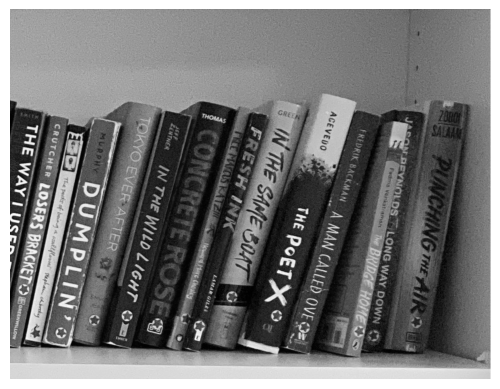

In [446]:

gray_image = np.mean(im, axis=-1)
plt.imshow(gray_image, cmap='gray')

# Optionally, remove the axes for a cleaner look
plt.axis('off')

# Show the image
plt.show()

# Show Slope, Width, Height 

In [358]:
for b in lines_in_books:
    for l in b['Lines']:
        text = l['DetectedText']
        print(text)
        slopes = [d['slopes'] for d in lines if d['DetectedText'] == text]
        print(f"\t{slopes}")
        width = [d['width'] for d in lines if d['DetectedText'] == text]
        height = [d['height'] for d in lines if d['DetectedText'] == text]
        print(f"\t{width}, {height}")
    print()

PUNCHING THE AIR
	[(-5.783777178741566, 0.17289722099166102)]
	[0.43506784472945187], [0.04849122174948131]
ZOBOI
	[(0.1428571442347685, -6.99992756240518)]
	[0.048080097359687025], [0.034011408677259644]
SALAAM
	[(0.12500019143949276, -8.000069787910297)]
	[0.06468424376861646], [0.03540851700854168]
JASON REYNOLDS
	[(-6.055542713019014, 0.16513725527026396)]
	[0.27751069713116167], [0.02510749542012401]

54
	[(0.23529163234018313, -4.25001732484957)]
	[0.02731826168024395], [0.019783587336101482]
IN THE WILD LIGHT
	[(-3.964280733210528, 0.2522538542766094)]
	[0.37829222535174645], [0.038635153391052196]
TOKYO EVER AFTER
	[(-3.8469682605649966, 0.25994387590631174)]
	[0.37344935736400947], [0.026688906358205578]
MURPHY
	[(-4.555548885960517, 0.21951232279852617)]
	[0.11432057099483557], [0.017851280458895807]

FREDRIK BACKMAN
	[(-3.400851060962679, 0.2940421929845498)]
	[0.20308624128017083], [0.019413541303426474]
A MAN CALLED OVE
	[(-3.4144442371269097, 0.2928747050775795)]
	[0.3010

In [359]:
lines_df = pd.DataFrame(lines)
lines_df

,DetectedText,Type,Id,Confidence,Geometry,slopes,height,width,mid_point,direction
0,PUNCHING THE AIR,LINE,0,99.037865,"{'BoundingBox': {'Width': 0.10469699651002884,...","(-5.783777178741566, 0.17289722099166102)",0.048491,0.435068,"(0.8721061497926712, 0.6091488897800446)",vertical right lean
1,ZOBOI,LINE,1,87.489677,"{'BoundingBox': {'Width': 0.05098944529891014,...","(0.1428571442347685, -6.99992756240518)",0.034011,0.048080,"(0.9147249609231949, 0.29130861163139343)",horizontal right lean
2,SALAAM,LINE,2,98.929657,"{'BoundingBox': {'Width': 0.0672382190823555, ...","(0.12500019143949276, -8.000069787910297)",0.035409,0.064684,"(0.9090651422739029, 0.3319786712527275)",horizontal right lean
3,LONG WAY DOWN,LINE,3,98.785255,{'BoundingBox': {'Width': 0.051028892397880554...,"(-6.111346939145252, 0.1636295145021403)",0.019680,0.254352,"(0.7769309729337692, 0.7251394242048264)",vertical right lean
4,JASON REYNOLDS,LINE,4,72.471039,"{'BoundingBox': {'Width': 0.05953611806035042,...","(-6.055542713019014, 0.16513725527026396)",0.025107,0.277511,"(0.8154236674308777, 0.4257769286632538)",vertical right lean
5,Padma Venkatraman THE BRIDGE HOME,LINE,5,92.497787,"{'BoundingBox': {'Width': 0.0955459251999855, ...","(-4.9230768456359595, 0.20312370046258893)",0.030237,0.429331,"(0.7601913511753082, 0.6396164372563362)",vertical right lean
6,FREDRIK BACKMAN,LINE,6,98.211304,"{'BoundingBox': {'Width': 0.06295910477638245,...","(-3.400851060962679, 0.2940421929845498)",0.019414,0.203086,"(0.713282510638237, 0.4217396602034569)",vertical right lean
7,A MAN CALLED OVE,LINE,7,99.143532,"{'BoundingBox': {'Width': 0.094212606549263, '...","(-3.4144442371269097, 0.2928747050775795)",0.029973,0.301071,"(0.6497639417648315, 0.6939733773469925)",vertical right lean
8,DE,LINE,8,34.541000,{'BoundingBox': {'Width': 0.034980613738298416...,"(-3.1666756857510494, 0.315790457549768)",0.023203,0.057227,"(0.6120167225599289, 0.8682906925678253)",vertical right lean
9,ACEVEDO,LINE,9,98.398460,"{'BoundingBox': {'Width': 0.04248607158660889,...","(-3.2608669682047515, 0.3066687846476127)",0.018518,0.110071,"(0.6625701785087585, 0.32931791990995407)",vertical right lean


In [360]:
im.shape

(805, 1046, 3)

# Group Lines By Confidence, Slope and Location

In [362]:
confidence_threshold = 50
slope_threshold = 0.036
related_text = {}

def temp_func():
    for b_idx, b in enumerate(lines_in_books):
        related_text[b_idx] = {}
        for l1_idx, l1 in enumerate(b['Lines']):
            if l1['LineConf'] <= confidence_threshold:
                continue
            related_text[b_idx][l1_idx] = []
            for l2_idx, l2 in enumerate(b['Lines']):
                if l2['LineConf'] <= confidence_threshold:
                    continue
                l1_detail = [d for d in lines if d['DetectedText'] == l1['DetectedText']][0]
                l2_detail = [d for d in lines if d['DetectedText'] == l2['DetectedText']][0]
                l1_slope = l1_detail['slopes']
                l2_slope = l2_detail['slopes']
                l1_direction = l1_detail['direction']
                l2_direction = l2_detail['direction']
                x_diff = abs(l1_slope[0]-l2_slope[0])
                y_diff = abs(l1_slope[1]-l2_slope[1])
                # print(l1['DetectedText'], '||',l2['DetectedText'], x_diff, y_diff)
                # if x_diff <= slope_threshold or y_diff <= slope_threshold:
                    # x1 = l1['LineBox']['Left'] * im.shape[1]
                    # x2 = l2['LineBox']['Left'] * im.shape[1]
                    # print(l1['DetectedText'], '||',l2['DetectedText'], x1, x2)       
                if "vertical" in l1_direction:
                    slope = l1_slope[0]
                    p1 = l1_detail['Geometry']['Polygon'][0]
                    p2 = l1_detail['Geometry']['Polygon'][3]
                elif "horizontal" in l1_direction:
                    slope = l1_slope[1]
                    p1 = l1_detail['Geometry']['Polygon'][0]
                    p2 = l1_detail['Geometry']['Polygon'][1]
                else:
                    print("===========================")
                    print("Invalid Direction")
                    print("===========================")
                    break
                if check_points(l2_detail['Geometry']['Polygon'], slope, p1, p2) >= 2:
                    related_text[b_idx][l1_idx].append((l2_idx, l2['DetectedText']))
                # if abs(x1-x2) < x_diff_threshold:
                #     related_text[b_idx][l1_idx].append((l2_idx, l2['DetectedText']))
temp_func()
related_text      

{0: {0: [(0, 'PUNCHING THE AIR'), (1, 'ZOBOI')],
  1: [(0, 'PUNCHING THE AIR'), (1, 'ZOBOI')],
  2: [(0, 'PUNCHING THE AIR'), (1, 'ZOBOI'), (2, 'SALAAM')],
  3: [(3, 'JASON REYNOLDS')]},
 1: {1: [], 2: [(2, 'TOKYO EVER AFTER')], 3: []},
 2: {0: [(0, 'FREDRIK BACKMAN')],
  1: [(0, 'FREDRIK BACKMAN'), (1, 'A MAN CALLED OVE')],
  3: [(3, 'ACEVEDO')],
  4: [(4, 'GREEN')]},
 3: {0: [(0, 'GREENWILLOW')],
  1: [(2, 'SMITH')],
  2: [(1, 'THE WAY I USED'), (2, 'SMITH')]},
 4: {1: [(1, 'THE PoET x')],
  2: [(2, 'GREEN'), (3, 'IN THE SAME BOAT')],
  3: [(2, 'GREEN')],
  4: [(5, 'LAMAR GILES')],
  5: [(5, 'LAMAR GILES')],
  7: [(7, 'THOMAS')]},
 5: {0: [(0, 'LONG WAY DOWN')],
  1: [(0, 'LONG WAY DOWN'), (1, 'JASON REYNOLDS')],
  2: [(1, 'JASON REYNOLDS'), (2, 'Padma Venkatraman THE BRIDGE HOME')],
  3: [(3, 'FREDRIK BACKMAN')],
  4: [(3, 'FREDRIK BACKMAN'), (4, 'A MAN CALLED OVE')],
  5: [(5, 'ACEVEDO')]},
 6: {0: [(0, 'LAMAR GILES')],
  2: [(2, 'CONCRETE ROSE')],
  3: [(2, 'CONCRETE ROSE'), (3, '

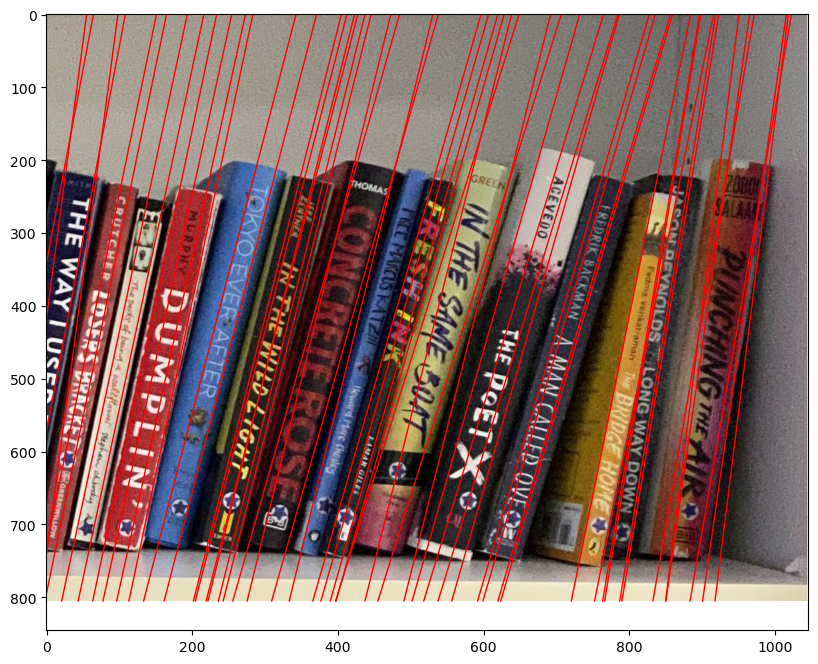

In [363]:
fix,ax = plt.subplots(figsize=(12, 8))
ax.imshow(im)

# for p in polygons:
    # ax.add_patch(p)

lst_no_duplicates = []
[lst_no_duplicates.append(x) for x in lines_to_plot if x not in lst_no_duplicates]
for l in lst_no_duplicates:
    ax.plot(l[0], l[1], color='red', linewidth=1)

plt.show()

In [311]:
for b in lines_in_books:
    for l_idx, l in enumerate(b['Lines']):
        print(f"{l_idx}, {l['DetectedText']}, {l['LineConf']}")
    print()

0, PUNCHING THE AIR, 99.0378646850586
1, ZOBOI, 87.48967742919922
2, SALAAM, 98.92965698242188
3, JASON REYNOLDS, 72.47103881835938

0, 54, 15.176762580871582
1, IN THE WILD LIGHT, 98.39309692382812
2, TOKYO EVER AFTER, 98.90113830566406
3, MURPHY, 97.2724838256836

0, FREDRIK BACKMAN, 98.2113037109375
1, A MAN CALLED OVE, 99.1435317993164
2, DE, 34.54100036621094
3, ACEVEDO, 98.3984603881836
4, GREEN, 98.0937271118164

0, GREENWILLOW, 91.48441314697266
1, THE WAY I USED, 91.3798599243164
2, SMITH, 94.05685424804688

0, DE, 34.54100036621094
1, THE PoET x, 76.27904510498047
2, GREEN, 98.0937271118164
3, IN THE SAME BOAT, 99.06768798828125
4, FRESH INK, 99.05506134033203
5, LAMAR GILES, 96.22512817382812
6, FREE MAKOUS KATZIII T Howard Marc Chosley, 48.6652946472168
7, THOMAS, 98.00833129882812

0, LONG WAY DOWN, 98.7852554321289
1, JASON REYNOLDS, 72.47103881835938
2, Padma Venkatraman THE BRIDGE HOME, 92.49778747558594
3, FREDRIK BACKMAN, 98.2113037109375
4, A MAN CALLED OVE, 99.14353

In [259]:
true_related = [
    ['The perks of being a wallflower stephen chooky'],
    ['MURPHY', "DUMPLIN'"],
    ['TOKYO EVER AFTER'],
    ['JEFF', 'ZENTNER', 'IN THE WILD LIGHT'],
    ['CONCRETE ROSE'],
    ['FRESH INK', 'LAMAR GILES'],
    ['IN THE SAME BOAT'],
    ['PUNCHING THE AIR'],
    ['ZOBOI', 'SALAAM'],
    ['JASON REYNOLDS', 'LONG WAY DOWN'],
    ['Padma Venkatraman THE BRIDGE HOME'],
    ['FREDRIK BACKMAN', 'A MAN CALLED OVE'],
    ['ACEVEDO', 'THE PoET x'],
    # ['JASON REYNOLDS', 'PUNCHING THE AIR'],
    # ['IN THE SAME BOAT', 'THE PoET x']
]

slope_dict = {}
for idx, lst in enumerate(true_related):
    if len(lst) < 2:
        continue
    slope_dict[idx] = []
    for i in lst:
        for l in lines:
            if l['DetectedText'] == i:
                if idx == 8:
                    print(l['DetectedText'])
                    print(l['slopes'])
                slope_dict[idx].append(l['slopes'])
                break

slope_diff = {}
slope_avg = {}
for k, v in slope_dict.items():
    slope_diff[k] = []
    for i in range(len(v)):
        for j in range(i+1, len(v)):
            if k == 8:
                print(v[i])
                print(v[j])
            x_diff = abs(v[i][0] - v[j][0])
            y_diff = abs(v[i][1] - v[j][1])
            slope_diff[k].append((x_diff, y_diff))
    x = [t[0] for t in slope_diff[k]]
    y = [t[1] for t in slope_diff[k]]
    x_avg = sum(x) / (len(v) - 1)
    y_avg = sum(y) / (len(v) - 1)
    slope_avg[k] = (x_avg, y_avg)

x = [t[0] for t in slope_avg.values()]
y = [t[1] for t in slope_avg.values()]
x_avg = sum(x) / len(slope_avg)
y_avg = sum(y) / len(slope_avg)
x_avg, y_avg, slope_avg


ZOBOI
(-0.24119792789100417, 11.818576050103784)
SALAAM
(-0.21104850809307057, 13.50720166053665)
(-0.24119792789100417, 11.818576050103784)
(-0.21104850809307057, 13.50720166053665)


(0.15636604484005717,
 0.2512324749766627,
 {1: (0.2968013851496307, 0.013769970658865205),
  3: (0.22509148379055954, 0.014559081216857561),
  5: (0.021616068900285335, 0.001777555108594342),
  8: (0.03014941979793359, 1.6886256104328652),
  9: (0.09421904505587975, 0.002545647618928837),
  11: (0.022950521248567668, 0.0019711696289845815),
  12: (0.4037343899375436, 0.035378290171543425)})

In [261]:
x_dict = {}
loc_dict = {}
for idx, lst in enumerate(true_related):
    if len(lst) < 2:
        continue
    x_dict[idx] = []
    loc_dict[idx] = []
    for i in lst:
        for l in lines:
            if l['DetectedText'] == i:
                x = l['Geometry']['BoundingBox']['Left']
                x_dict[idx].append(x)
                loc_dict[idx].append((l['width'] * im.shape[1], l['height'] * im.shape[0]))
                break
x_diff = {}
x_avg = {}
for k, v in x_dict.items():
    x_diff[k] = []
    for i in range(len(v)):
        for j in range(i+1, len(v)):
            i_width = loc_dict[k][i][0]
            i_height = loc_dict[k][i][1]
            j_width = loc_dict[k][j][0]
            j_height = loc_dict[k][j][1]
            x_dif = abs(v[i] - v[j]) * im.shape[1]
            x_dist = x_dif / (i_width * j_width)
            x_diff[k].append(x_dist)
    x_av = sum(x_diff[k]) / len(v)
    x_avg[k] = x_av

x_av = sum(x_avg.values()) / len(x_avg)
x_av, x_avg, x_diff


(0.057083420028560476,
 {1: 0.04616489497624024,
  3: 0.14112637366083475,
  5: 0.050645132352651064,
  8: 0.0054712740094528655,
  9: 0.03312366878387364,
  11: 0.06501652742333269,
  12: 0.05803606899353808},
 {1: [0.09232978995248048],
  3: [0.0879529453645408, 0.18636519616051342, 0.14906097945745],
  5: [0.10129026470530213],
  8: [0.010942548018905731],
  9: [0.06624733756774728],
  11: [0.13003305484666539],
  12: [0.11607213798707616]})

In [266]:
for l in lines:
    a = l['Geometry']['Polygon'][0]
    b = l['Geometry']['Polygon'][1]
    c = l['Geometry']['Polygon'][2]
    d = l['Geometry']['Polygon'][3]
    
    min_y = min(a['Y'], b['Y'], c['Y'], d['Y'])
    max_x = max(a['X'], b['X'], c['X'], d['X'])
    
    if a['X'] != max_x and a['Y'] != min_y:
        print(l['DetectedText'])
        print(l['Geometry']['Polygon'])
        print()

PUNCHING THE AIR
[{'X': 0.9244546294212341, 'Y': 0.3988300561904907}, {'X': 0.8670696020126343, 'Y': 0.8300967812538147}, {'X': 0.8197576403617859, 'Y': 0.8194677233695984}, {'X': 0.8771427273750305, 'Y': 0.3882009983062744}]

LONG WAY DOWN
[{'X': 0.8024454116821289, 'Y': 0.6010061502456665}, {'X': 0.7706659436225891, 'Y': 0.8533654808998108}, {'X': 0.7514165043830872, 'Y': 0.8492727279663086}, {'X': 0.7831960320472717, 'Y': 0.5969133377075195}]

JASON REYNOLDS
[{'X': 0.8451917171478271, 'Y': 0.2907625436782837}, {'X': 0.8102043271064758, 'Y': 0.566058874130249}, {'X': 0.7856556177139282, 'Y': 0.5607913136482239}, {'X': 0.8206430077552795, 'Y': 0.28549498319625854}]

Padma Venkatraman THE BRIDGE HOME
[{'X': 0.8079643249511719, 'Y': 0.43138524889945984}, {'X': 0.7416546940803528, 'Y': 0.8555641174316406}, {'X': 0.7124183773994446, 'Y': 0.8478476405143738}, {'X': 0.7787280082702637, 'Y': 0.4236687421798706}]

FREDRIK BACKMAN
[{'X': 0.7447620630264282, 'Y': 0.32616519927978516}, {'X': 0.6

In [ ]:

texts_in_multiple = set()  # Using a set for efficient look-up
for text_list in related_text.values():
    if len(text_list) > 1:
        for _, text in text_list:
            texts_in_multiple.add(text)

# Step 2: Remove key-value pairs where the text is the only element and also appears in texts_in_multiple
keys_to_remove = [key for key, text_list in related_text.items() if len(text_list) == 1 and text_list[0][1] in texts_in_multiple]

for key in keys_to_remove:
    del related_text[key]

print(related_text)

# Show Duplicate Lines

In [163]:
line_to_books = {}
for book_idx, book in enumerate(lines_in_books):
    for line in book['Lines']:
        text = line['DetectedText']
        if text in line_to_books:
            line_to_books[text].append(book_idx)
        else:
            line_to_books[text] = [book_idx]
line_to_books

{'PUNCHING THE AIR': [0],
 'ZOBOI': [0],
 'SALAAM': [0],
 'JASON REYNOLDS': [0, 5],
 '54': [1, 9],
 'IN THE WILD LIGHT': [1, 9],
 'TOKYO EVER AFTER': [1, 9],
 'MURPHY': [1, 8],
 'FREDRIK BACKMAN': [2, 5],
 'A MAN CALLED OVE': [2, 5, 7],
 'DE': [2, 4, 7],
 'ACEVEDO': [2, 5, 7],
 'GREEN': [2, 4, 7],
 'GREENWILLOW': [3],
 'THE WAY I USED': [3],
 'SMITH': [3],
 'THE PoET x': [4, 7],
 'IN THE SAME BOAT': [4, 7],
 'FRESH INK': [4],
 'LAMAR GILES': [4, 6],
 'FREE MAKOUS KATZIII T Howard Marc Chosley': [4, 6],
 'THOMAS': [4, 6],
 'LONG WAY DOWN': [5],
 'Padma Venkatraman THE BRIDGE HOME': [5],
 'CONCRETE ROSE': [6],
 'JEFF': [6, 9],
 'ZENTNER': [6, 9],
 "DUMPLIN'": [8],
 'The perks of being a wallflower stephen chooky': [8]}

# Remove Duplicate Lines

In [165]:
for line_text, book_idxs in line_to_books.items():
    if len(book_idxs) > 1:
        print(f"Line '{line_text}' found in multiple books:")
        line = next((line for line in lines if line['DetectedText'] == line_text), None)
        print()
        overlap_percent = {}
        for book_idx in book_idxs:
            book = lines_in_books[book_idx]
            overlap_percent[book_idx] = calc_overlap_percentage(
                line['Geometry']['BoundingBox'],
                book['BookBox']
            )
        print(overlap_percent)
        # Find the largest value
        max_value = max(overlap_percent.values())
        keys_with_max_value = [key for key, value in overlap_percent.items() if value == max_value]
        other_keys = [key for key, value in overlap_percent.items() if value != max_value]
        print(f"The largest Overlap is {max_value}. Books with this value are: {keys_with_max_value}")
        
        print(f"Removing books: {other_keys}")
        
        for k in other_keys:
            lines_in_books[k]['Lines'] = [l for l in lines_in_books[k]['Lines'] if l.get('DetectedText') != line_text]
            
        print()  # Newline for better readability

Line 'JASON REYNOLDS' found in multiple books:

{0: 0.9892075921035466, 5: 1.0}
The largest Overlap is 1.0. Books with this value are: [5]
Removing books: [0]

Line '54' found in multiple books:

{1: 1.0, 9: 1.0}
The largest Overlap is 1.0. Books with this value are: [1, 9]
Removing books: []

Line 'IN THE WILD LIGHT' found in multiple books:

{1: 0.7848806251982368, 9: 1.0}
The largest Overlap is 1.0. Books with this value are: [9]
Removing books: [1]

Line 'TOKYO EVER AFTER' found in multiple books:

{1: 1.0, 9: 1.0}
The largest Overlap is 1.0. Books with this value are: [1, 9]
Removing books: []

Line 'MURPHY' found in multiple books:

{1: 1.0, 8: 1.0}
The largest Overlap is 1.0. Books with this value are: [1, 8]
Removing books: []

Line 'FREDRIK BACKMAN' found in multiple books:

{2: 1.0, 5: 1.0}
The largest Overlap is 1.0. Books with this value are: [2, 5]
Removing books: []

Line 'A MAN CALLED OVE' found in multiple books:

{2: 1.0, 5: 0.7655535364881714, 7: 1.0}
The largest Over

# Show Lines in Each Book

In [356]:
for book_idx, book in enumerate(lines_in_books):
    print(f"Book: {book_idx}")
    for line in book['Lines']:
        print(line['DetectedText'])
    print()

Book: 0
PUNCHING THE AIR
ZOBOI
SALAAM
JASON REYNOLDS

Book: 1
54
IN THE WILD LIGHT
TOKYO EVER AFTER
MURPHY

Book: 2
FREDRIK BACKMAN
A MAN CALLED OVE
DE
ACEVEDO
GREEN

Book: 3
GREENWILLOW
THE WAY I USED
SMITH

Book: 4
DE
THE PoET x
GREEN
IN THE SAME BOAT
FRESH INK
LAMAR GILES
FREE MAKOUS KATZIII T Howard Marc Chosley
THOMAS

Book: 5
LONG WAY DOWN
JASON REYNOLDS
Padma Venkatraman THE BRIDGE HOME
FREDRIK BACKMAN
A MAN CALLED OVE
ACEVEDO

Book: 6
LAMAR GILES
FREE MAKOUS KATZIII T Howard Marc Chosley
CONCRETE ROSE
THOMAS
JEFF
ZENTNER

Book: 7
A MAN CALLED OVE
DE
ACEVEDO
THE PoET x
GREEN
IN THE SAME BOAT

Book: 8
MURPHY
DUMPLIN'
The perks of being a wallflower stephen chooky

Book: 9
54
JEFF
ZENTNER
IN THE WILD LIGHT
TOKYO EVER AFTER


### Group Words

In [ ]:
word_book_overlap_threshold = 0.7
orphan_words = []
for b in all_books:
    book_box = b['BoundingBox']
    book_conf = b['Confidence']
    word_lst = []
    for w in words:
        word_box = w['Geometry']['BoundingBox']
        if a_in_b(word_box, book_box, word_book_overlap_threshold):
            word_lst.append({
                'DetectedText': w['DetectedText'],
                'WordConf': w['Confidence'],
                'WordBox': word_box,
                'WordPolygon': w['Geometry']['Polygon']
            })
    if len(word_lst) == 0:
        pass
    orphan_words.append({
        'BookBox': book_box,
        'BookConf': book_conf,
        'Words': word_lst
    })
# 
for book in orphan_words:
    fix,ax = plt.subplots(figsize=(12, 8))
    ax.imshow(im)

    ax.add_patch(draw_rectangle(get_rect(book['BookBox'], im)))
    rects = [draw_rectangle(get_rect(annotation['WordBox'], im), color='blue')
             for annotation in book['Words']]

    for rect in rects:
        ax.add_patch(rect)

    plt.show()

In [182]:
polygon = [ {'X': 0.3567297160625458, 'Y': 0.31739163398742676},
            {'X': 0.3491596579551697, 'Y': 0.3567369878292084},
            {'X': 0.33620965480804443, 'Y': 0.35253027081489563},
            {'X': 0.34377971291542053, 'Y': 0.3131848871707916}]

vertices = [(p["X"] * im.shape[1], p["Y"] * im.shape[0]) for p in polygon]
vertices

[(373.1392830014229, 255.50026535987854),
 (365.2210022211075, 287.17327520251274),
 (351.6752989292145, 283.786868005991),
 (359.5935797095299, 252.11383417248726)]

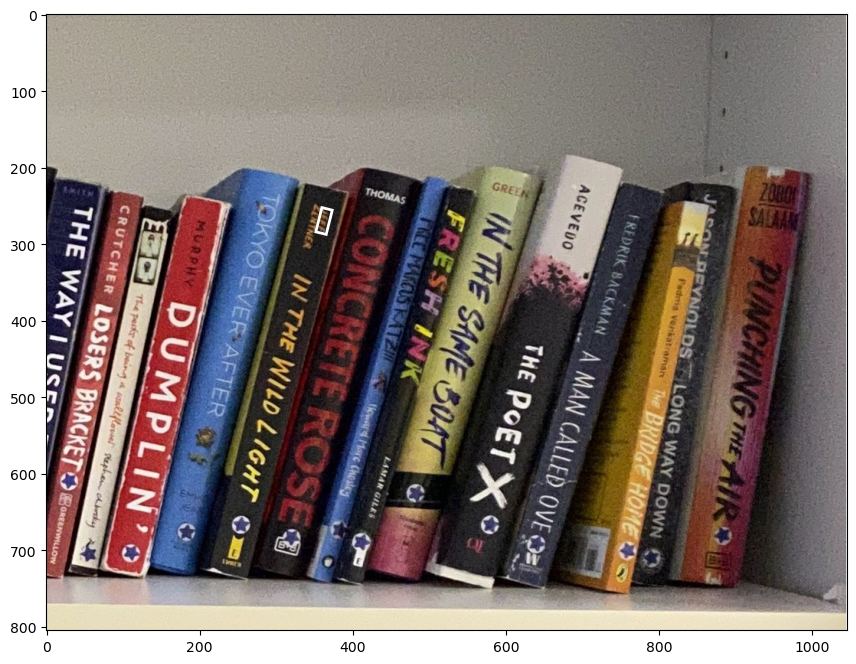

In [183]:
from matplotlib.patches import Polygon
fix,ax = plt.subplots(figsize=(12, 8))
ax.imshow(im)

polygon_patch = Polygon(vertices, closed=True, edgecolor='white', fill=False, linewidth=2)

ax.add_patch(polygon_patch)

plt.show()

In [140]:
def calc_overlap_percentage(a_box, b_box):
    left1, top1 = a_box['Left'], a_box['Top']
    right1, bottom1 = a_box['Left'] + a_box['Width'], a_box['Top'] + a_box['Height']
    left2, top2 = b_box['Left'], b_box['Top']
    right2, bottom2 = b_box['Left'] + b_box['Width'], b_box['Top'] + b_box['Height']

    overlap_left = max(left1, left2)
    overlap_top = max(top1, top2)
    overlap_right = min(right1, right2)
    overlap_bottom = min(bottom1, bottom2)

    if overlap_left < overlap_right and overlap_top < overlap_bottom:
        # Calculate overlap dimensions
        overlap_width = overlap_right - overlap_left
        overlap_height = overlap_bottom - overlap_top
        overlap_area = overlap_width * overlap_height
    else:
        # No overlap
        overlap_area = 0

    a_area = a_box['Width'] * a_box['Height']
    overlap_percent = overlap_area / a_area
    return overlap_percent

def a_in_b(a_box, b_box, percentage_threshold: float = 0.9):
    overlap_percent = calc_overlap_percentage(a_box, b_box)
    if overlap_percent >= percentage_threshold:
        return True
    return False

### Collect Orphan Words

In [124]:
for l in lines:
    if l['Confidence'] > 50:
        print(l['DetectedText'])
        split_words = l['DetectedText'].split()
        for sw in split_words:
            for w in words:
                if sw == w['DetectedText']:
                    # print(w['DetectedText'])
                    words.remove(w)
                    break

PUNCHING THE AIR
ZOBOI
SALAAM
LONG WAY DOWN
JASON REYNOLDS
Padma Venkatraman THE BRIDGE HOME
FREDRIK BACKMAN
A MAN CALLED OVE
ACEVEDO
THE PoET x
GREEN
IN THE SAME BOAT
FRESH INK
LAMAR GILES
CONCRETE ROSE
THOMAS
JEFF
ZENTNER
IN THE WILD LIGHT
TOKYO EVER AFTER
MURPHY
DUMPLIN'
The perks of being a wallflower stephen chooky
GREENWILLOW
CRUTCHER LOSERS BRACKET
THE WAY I USED
SMITH


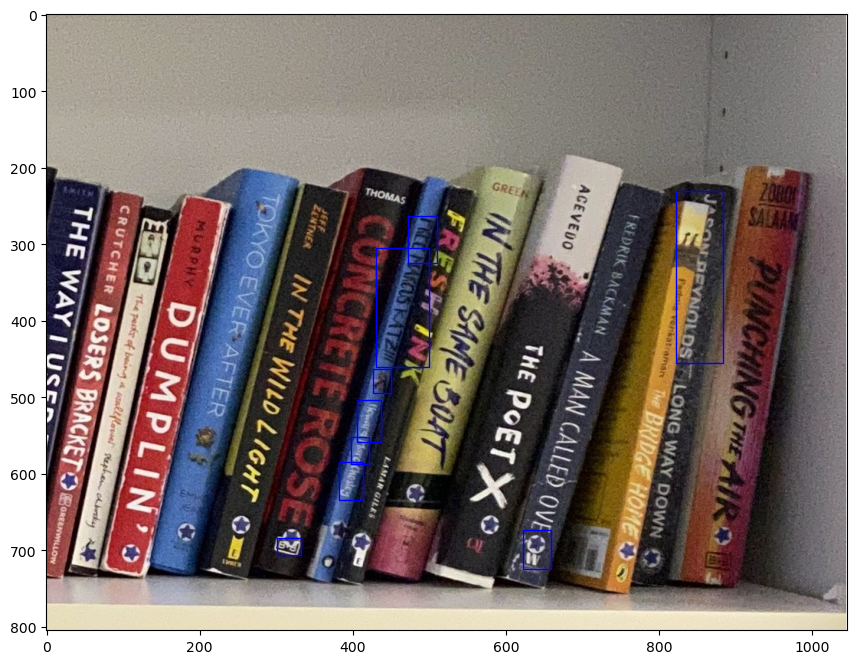

In [125]:
fix,ax = plt.subplots(figsize=(12, 8))
ax.imshow(im)

orphan_words_rects = [draw_rectangle(get_text_data(annotation, im), color='blue')
                  for annotation in words]

for rect in orphan_words_rects:
    ax.add_patch(rect)

plt.show()

# Group Lines and Words by Overlap Area Percentage

In [ ]:
line_book_overlap_threshold = 0.7
lines_in_books = []
for b in all_books:
    book_box = b['BoundingBox']
    book_conf = b['Confidence']
    line_lst = []
    for l in lines:
        line_box = l['Geometry']['BoundingBox']
        if a_in_b(line_box, book_box, line_book_overlap_threshold):
            line_lst.append({
                'DetectedText': l['DetectedText'],
                'LineConf': l['Confidence'],
                'LineBox': line_box,
                'LinePolygon': l['Geometry']['Polygon']
            })
    lines_in_books.append({
        'BookBox': book_box,
        'BookConf': book_conf,
        'Lines': line_lst
    })

for book in lines_in_books:
    fix,ax = plt.subplots(figsize=(12, 8))
    ax.imshow(im)

    ax.add_patch(draw_rectangle(get_rect(book['BookBox'], im)))
    rects = [draw_rectangle(get_rect(annotation['LineBox'], im), color='blue')
             for annotation in book['Lines']]

    for rect in rects:
        ax.add_patch(rect)

    plt.show()

### Show Orphan Words